In [1]:
import os.path
import json
import re
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import csaps

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [4]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/initial')

In [5]:
!ls $results_dir

1_1_RS_2019-07.jsonl  2_2_RS_2019-07.jsonl  4_3_RS_2019-07.jsonl
2_1_RS_2019-07.jsonl  4_2_RS_2019-07.jsonl  4_4_RS_2019-07.jsonl


In [30]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    partitions, threads, filename  = os.path.splitext(os.path.basename(path))[0].split('_', 2)
    with open(path) as fp:            
        df = pd.DataFrame([list(map(int, re.match(r'{time=(\d+), writes=(\d+), size=(\d+)}', line.strip()).groups()))
                           for line in fp], columns=['time', 'writes', 'size'])
    results.append([int(partitions), int(threads), filename, df])
results = pd.DataFrame(results, columns=['partitions', 'threads', 'filename', 'results'])
results

,partitions,threads,filename,results
0,4,3,RS_2019-07,time writes size 0 11523732452855 0 0 1 11524...
1,2,2,RS_2019-07,time writes size 0 10283701380575 0 0 1 10284...
2,4,2,RS_2019-07,time writes size 0 10887708109997 0 0 1 10888...
3,4,4,RS_2019-07,time writes size 0 12139579614612 0 0 1 12140...
4,1,1,RS_2019-07,time writes size 0 8877760865172 0 0 1 8878840...
5,2,1,RS_2019-07,time writes size 0 9541876851583 0 0 1 9542...


In [35]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 60e9

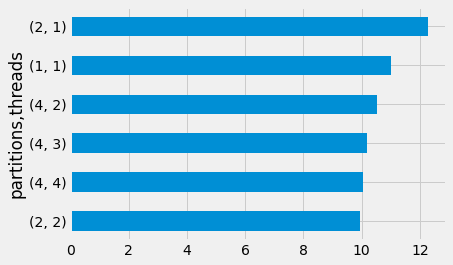

In [42]:
results.set_index(['partitions', 'threads'])['duration'].sort_values().plot.barh()

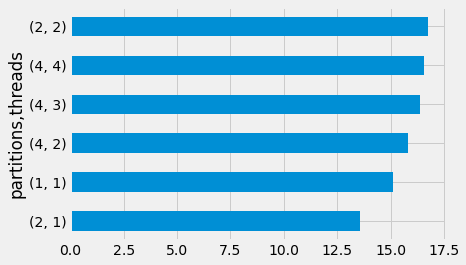

In [45]:
(1e7/ 60 / 1000 / results.set_index(['partitions', 'threads'])['duration']).sort_values().plot.barh()

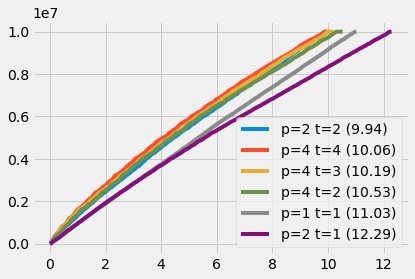

In [37]:
for _, row in results.sort_values('duration').iterrows():
    x = row['results']
    t = x['time']
    t = (t - t.iloc[0]) / 1e9 / 60
    plt.plot(t, x['writes'], label=f'p={row["partitions"]} t={row["threads"]} ({row["duration"]:.2f})')
plt.legend()
    

In [38]:
results['max_size'] = results['results'].map(lambda x: x['size'].max())
results['max_size'] /= 1e9

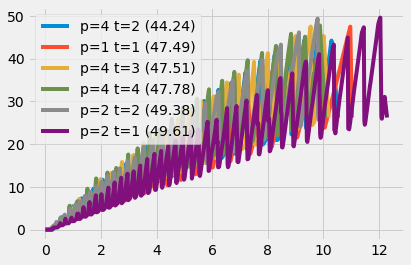

In [40]:
for _, row in results.sort_values('max_size').iterrows():
    x = row['results']
    t = x['time']
    t = (t - t.iloc[0]) / 60e9
    plt.plot(t, x['size'] / 1e9, label=f'p={row["partitions"]} t={row["threads"]} ({row["max_size"]:.2f})')
plt.legend()
    

In [46]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/initial_c5d.9xlarge')
!ls $results_dir

1_1_1.jsonl  1_2_1.jsonl  2_2_2.jsonl  4_8_4.jsonl  8_8_16.jsonl
1_1_2.jsonl  1_2_2.jsonl  4_4_4.jsonl  4_8_8.jsonl  8_8_8.jsonl


In [47]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    partitions, read_threads, write_threads  = os.path.splitext(os.path.basename(path))[0].split('_', 2)
    df = pd.read_json(path, lines=True)
    results.append([int(partitions), int(read_threads), int(write_threads), df])
results = pd.DataFrame(results, columns=['partitions', 'read_threads', 'write_threads', 'results'])
results

,partitions,read_threads,write_threads,results
0,2,2,2,time writes size 0 16777797909236 0 0 1 16778...
1,8,8,8,time writes size 0 15308167215336 0 0 1 15309...
2,4,4,4,time writes size 0 14743827532551 0 0 1 14744...
3,4,8,4,time writes size 0 15051783419068 0 0 1 15052...
4,8,8,16,time writes size 0 15452303838457 0 0 1 15453...
5,1,1,1,time writes size 0 15707500590888 0 0 1 15708...
6,1,2,2,time writes size 0 16034976919989 0 0 1 16036...
7,1,1,2,time writes size 0 16234359874338 0 0 1 16235...
8,4,8,8,time writes size 0 15185669995593 0 0 1 15186...
9,1,2,1,time writes size 0 16460731609893 0 0 1 16461...


In [48]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 60e9

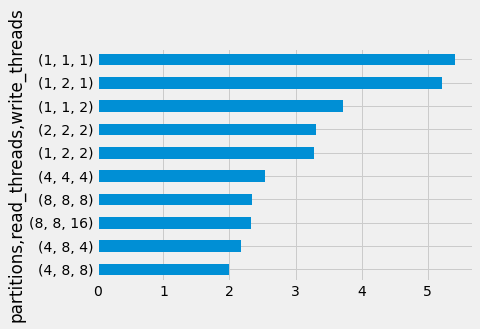

In [50]:
results.set_index(['partitions', 'read_threads', 'write_threads'])['duration'].sort_values().plot.barh()

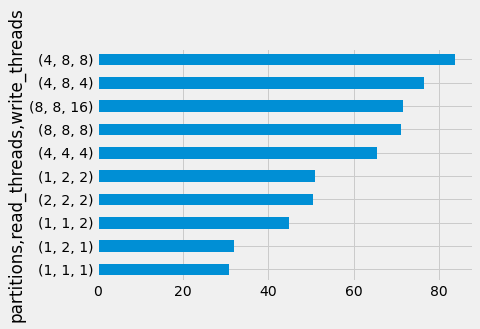

In [58]:
(1e7/ 60 / 1000 / results.set_index(['partitions', 'read_threads', 'write_threads'])['duration']).sort_values().plot.barh()

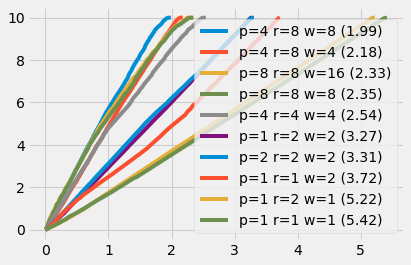

In [53]:
for _, row in results.sort_values('duration').iterrows():
    x = row['results']
    t = x['time']
    t = (t - t.iloc[0]) / 1e9 / 60
    plt.plot(t, x['writes'] / 1e6,
             label=f'p={row["partitions"]} r={row["read_threads"]} w={row["write_threads"]} ({row["duration"]:.2f})')
plt.legend()

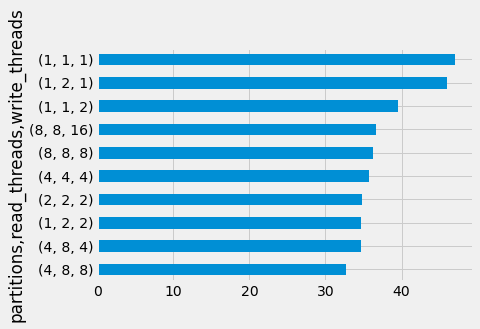

In [54]:
results['max_size'] = results['results'].map(lambda x: x['size'].max())
results['max_size'] /= 1e9
results.set_index(['partitions', 'read_threads', 'write_threads'])['max_size'].sort_values().plot.barh()

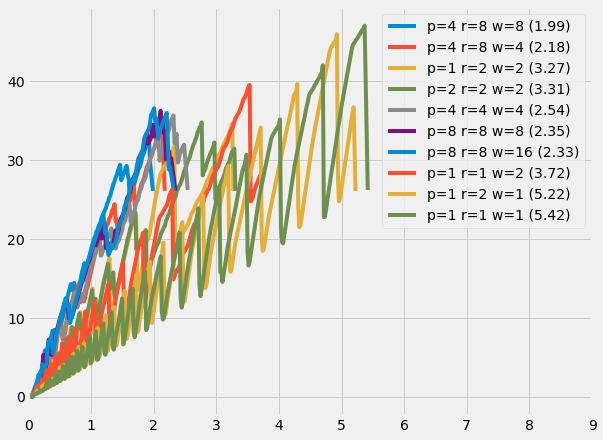

In [57]:
plt.figure(figsize=(9, 7))
for _, row in results.sort_values('max_size').iterrows():
    x = row['results']
    t = x['time']
    t = (t - t.iloc[0]) / 60e9
    plt.plot(t, x['size'] / 1e9,
            label=f'p={row["partitions"]} r={row["read_threads"]} w={row["write_threads"]} ({row["duration"]:.2f})')
plt.xlim(0, 9) 
plt.legend()


In [102]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/initial_c5d.9xlarge_full_comments')
!ls $results_dir

1_1_1.jsonl  1_2_2.jsonl  4_4_4.jsonl.tmp  8_8_16.jsonl
1_1_2.jsonl  2_2_2.jsonl  4_8_4.jsonl	   8_8_8.jsonl
1_2_1.jsonl  4_4_4.jsonl  4_8_8.jsonl


In [103]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    partitions, read_threads, write_threads  = os.path.splitext(os.path.basename(path))[0].split('_', 2)
    df = pd.read_json(path, lines=True)
    results.append([int(partitions), int(read_threads), int(write_threads), df])
results = pd.DataFrame(results, columns=['partitions', 'read_threads', 'write_threads', 'results'])
results

,partitions,read_threads,write_threads,results
0,2,2,2,time writes size 0 31468712852149 0 0 1 ...
1,8,8,8,time writes size 0 36459686460906 0 0 1 3...
2,4,4,4,time writes size 0 33190105660370 0 0 1 ...
3,4,8,4,time writes size 0 34419263270740 0 0 1 ...
4,8,8,16,time writes size 0 37594487722914 0 0 1 3...
5,1,1,1,time writes size 0 24235974339932 0 0 1 ...
6,1,2,2,time writes size 0 26184369920402 0 0 1 ...
7,1,1,2,time writes size 0 27533314265668 0 0 1 ...
8,4,8,8,time writes size 0 35508432313383 0 0 1 3...
9,1,2,1,time writes size 0 29449929479675 0 0 1 ...


In [104]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 60e9

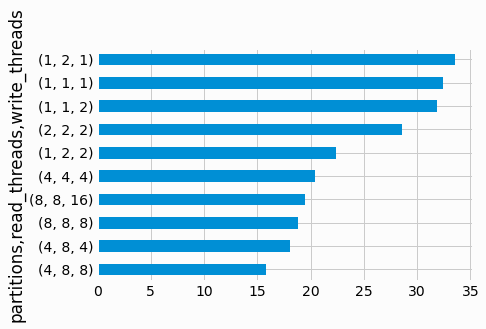

In [105]:
results.set_index(['partitions', 'read_threads', 'write_threads'])['duration'].sort_values().plot.barh()

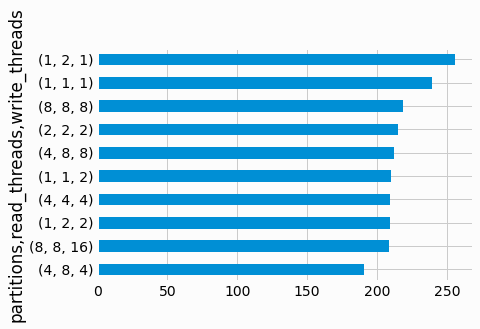

In [106]:
results['max_size'] = results['results'].map(lambda x: x['size'].max())
results['max_size'] /= 1e9
results.set_index(['partitions', 'read_threads', 'write_threads'])['max_size'].sort_values().plot.barh()

In [116]:
def min_duration(df):
    return df.loc[df['duration'].idxmin()]

partition_min_duration = results.groupby('partitions').apply(min_duration).drop('partitions', axis=1)
partition_min_duration

,read_threads,write_threads,results,duration,max_size
partitions,,,,,
1,2,2,time writes size 0 26184369920402 0 0 1 ...,22.419128,209.066861
2,2,2,time writes size 0 31468712852149 0 0 1 ...,28.624965,214.612472
4,8,8,time writes size 0 35508432313383 0 0 1 3...,15.791513,211.989177
8,8,8,time writes size 0 36459686460906 0 0 1 3...,18.848137,218.538742


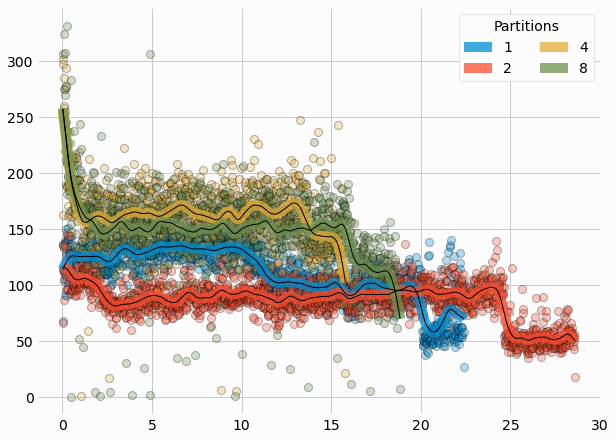

In [120]:
plt.figure(figsize=(9,7))
x = results.groupby('partitions').max
for color,(partitions, row) in zip(colors, partition_min_duration.iterrows()):
    x = row['results']
    t = x['time']
    t = np.array(t.iloc[1::] - t.iloc[0]) / 60e9
    w = np.array(x['writes']) / 1000
    w = w[1::] - w[:-1:]
    plt.plot(t, w, 'o', color=color, alpha=0.3, ms=8, zorder=1, mec='k')
    
    ws = csaps.csaps(t, w, t, smooth=0.9)
    plt.plot(t, ws, '-', color=color, lw=10, alpha=0.75, zorder=2, label=partitions)
    plt.plot(t, ws, '-', color='k', lw=1, alpha=1, zorder=3)


plt.legend(loc='upper right', ncol=2, title='Partitions', framealpha=1)

In [72]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/get_initial')
!ls $results_dir

get_results_intern.jsonl  get_results.jsonl


In [92]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    name  = os.path.splitext(os.path.basename(path))[0]
    df = []
    with open(path, 'r') as fp:
        for line in fp:
            if line.startswith('{'):
                df.append(json.loads(line))
    df = pd.DataFrame(df)
    results.append([name, df])
results = pd.DataFrame(results, columns=['name', 'results'])
results

,name,results
0,get_results_intern,time remaining size 0 6680590467756 9999983 154497019784 1 668...
1,get_results,time remaining size 0 4449938792587 9999979 154497019784 1 445...
2,get_results_intern5,time remaining size 0 10897159173314 9999979 154497019784 1 1...
3,get_results_intern3,time remaining size 0 8227638704219 9999997 154497019784 1 822...
4,get_results_intern2,time remaining size 0 7628385158290 9999997 154497019784 1 762...
5,get_results_intern4,time remaining size 0 9559713955549 9999997 154497019784 1 956...


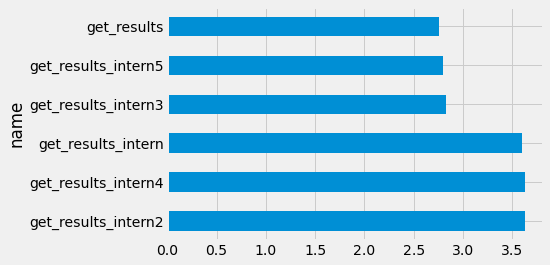

In [93]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 60e9
results.set_index('name')['duration'].sort_values(ascending=False).plot.barh()

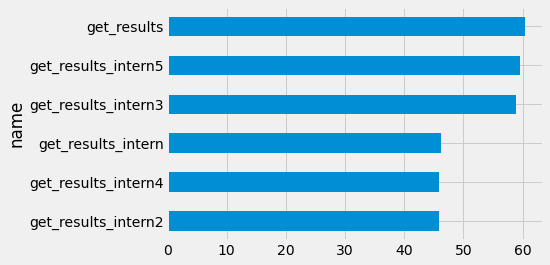

In [94]:
get_keys = 10000000
results['rate'] = (get_keys / (results['duration'] * 60) / 1000)
results.set_index('name')['rate'].sort_values().plot.barh()

In [99]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/get_initial_threads')
!ls $results_dir

4_16.jsonl  4_48.jsonl	4_8.jsonl   8_2.jsonl	8_64.jsonl
4_1.jsonl   4_4.jsonl	4_96.jsonl  8_32.jsonl	8_80.jsonl
4_2.jsonl   4_64.jsonl	8_16.jsonl  8_48.jsonl	8_8.jsonl
4_32.jsonl  4_80.jsonl	8_1.jsonl   8_4.jsonl	8_96.jsonl


In [100]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    partitions, threads  = map(int, os.path.splitext(os.path.basename(path))[0].split('_'))
    df = []
    with open(path, 'r') as fp:
        for line in fp:
            if line.startswith('{'):
                df.append(json.loads(line))
    df = pd.DataFrame(df)
    results.append([partitions, threads, df])
results = pd.DataFrame(results, columns=['partitions', 'threads', 'results'])
results

,partitions,threads,results
0,8,16,time gets size 0 5344058880639 0 154497019784 1 5345216...
1,4,2,time gets size 0 16670255197219 0 154498682063 1 16671...
2,4,80,time gets size 0 18067227858287 0 154498682063 1 180...
3,4,1,time gets size 0 16471762124960 0 154498682063 1 1647282...
4,8,4,time gets size 0 4944586806094 0 154497019784 1 4945632...
5,4,96,time gets size 0 18266940735994 0 154498682063 1 182...
6,4,64,time gets size 0 17867400363244 0 154498682063 1 178...
7,8,48,time gets size 0 5743071701345 0 154497019784 1 57442...
8,8,8,time gets size 0 5144302650354 0 154497019784 1 5145380...
9,4,48,time gets size 0 17667607635069 0 154498682063 1 176...


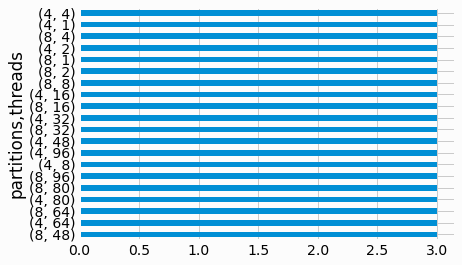

In [101]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 1e9
results.set_index(['partitions', 'threads'])['duration'].div(60).sort_values(ascending=False).plot.barh()

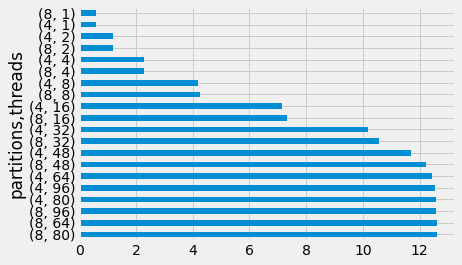

In [139]:
results['gets'] = results['results'].map(lambda x: x['gets'].iloc[-1])
results.set_index(['partitions', 'threads'])['gets'].sort_values(ascending=False).div(1e6).plot.barh()

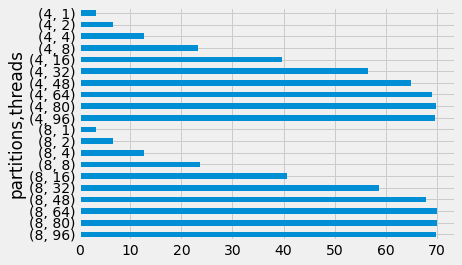

In [140]:
results['get_rate'] = results['gets'] / results['duration']
results.set_index(['partitions', 'threads'])['get_rate'].sort_index(ascending=False).div(1e3).plot.barh()

([<matplotlib.axis.XTick at 0x7f7a6b0b66d8>,
 [Text(0, 0, '16'),
  Text(0, 0, '4'),
  Text(0, 0, '48'),
  Text(0, 0, '8'),
  Text(0, 0, '32'),
  Text(0, 0, '2'),
  Text(0, 0, '64'),
  Text(0, 0, '80'),
  Text(0, 0, '96'),
  Text(0, 0, '1')])

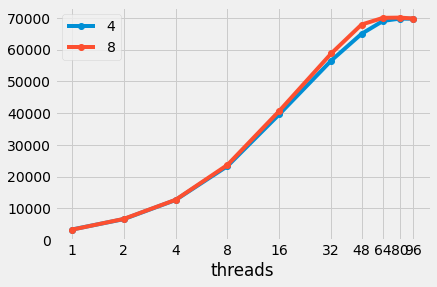

In [143]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for partitions, x in results.groupby('partitions'):
    x.sort_values('threads').plot('threads', 'get_rate', style='o-', label=str(partitions), ax=ax)
plt.xscale('log')
plt.xticks(x['threads'], x['threads'])

([<matplotlib.axis.XTick at 0x7f7a6b550048>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '4'),
  Text(0, 0, '8'),
  Text(0, 0, '16'),
  Text(0, 0, '32'),
  Text(0, 0, '48'),
  Text(0, 0, '64'),
  Text(0, 0, '80'),
  Text(0, 0, '96')])

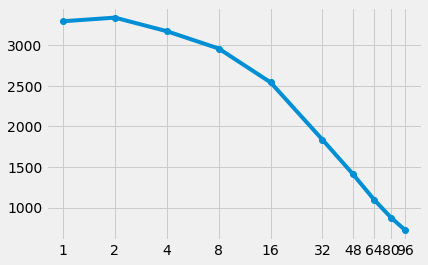

In [135]:
x = results.sort_values('threads')
plt.plot(x['threads'], x['get_rate'] / x['threads'], 'o-')
plt.xscale('log')
plt.xticks(x['threads'], x['threads'])

In [3]:
results_dir = os.path.expanduser('~/PycharmProjects/benchmarking_test/results/doc/results_update')
!ls $results_dir

4_16.jsonl  4_2.jsonl	4_48.jsonl  4_64.jsonl	4_8.jsonl
4_1.jsonl   4_32.jsonl	4_4.jsonl   4_80.jsonl	4_96.jsonl


In [92]:
results = []
for path in glob(results_dir + '/*.jsonl'):
    partitions, threads  = map(int, os.path.splitext(os.path.basename(path))[0].split('_'))
    df = []
    with open(path, 'r') as fp:
        for line in fp:
            if line.startswith('{'):
                df.append(json.loads(line))
    df = pd.DataFrame(df)
    results.append([partitions, threads, df])
results = pd.DataFrame(results, columns=['partitions', 'threads', 'results'])
results

,partitions,threads,results
0,4,2,time updates size 0 32662953358267 0 154498682063 1 32...
1,4,80,time updates size 0 41267370791878 0 154498682063 1 ...
2,4,1,time updates size 0 31434341659383 0 154498682063 1 31...
3,4,96,time updates size 0 42494023376191 0 154498682063 1 ...
4,4,64,time updates size 0 40040583888061 0 154498682063 1 ...
5,4,48,time updates size 0 38811707987274 0 154498682063 1 ...
6,4,16,time updates size 0 36349532027162 0 154498682063 1 36...
7,4,32,time updates size 0 37582402868703 0 154498682063 1 ...
8,4,4,time updates size 0 33891490204729 0 154498682063 1 33...
9,4,8,time updates size 0 35119481159050 0 154498682063 1 35...


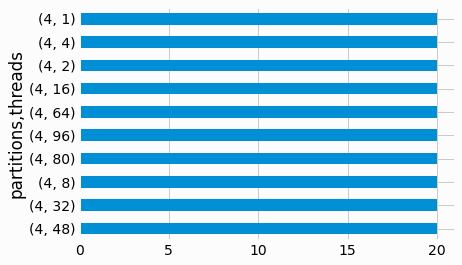

In [93]:
results['duration'] = results['results'].map(lambda x: x['time'].iloc[-1] - x['time'].iloc[0])
results['duration'] /= 1e9
results.set_index(['partitions', 'threads'])['duration'].div(60).sort_values(ascending=False).plot.barh()

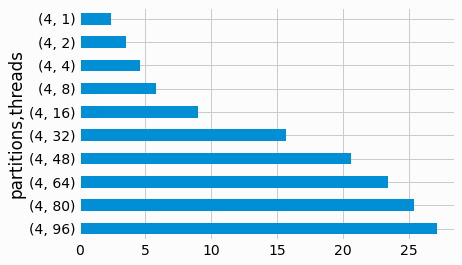

In [94]:
results['updates'] = results['results'].map(lambda x: x['updates'].iloc[-1])
results.set_index(['partitions', 'threads'])['updates'].sort_values(ascending=False).div(1e6).plot.barh()

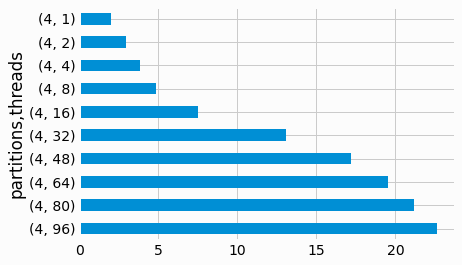

In [95]:
results['rate'] = results['updates'] / results['duration']
results.set_index(['partitions', 'threads'])['rate'].sort_index(ascending=False).div(1e3).plot.barh()

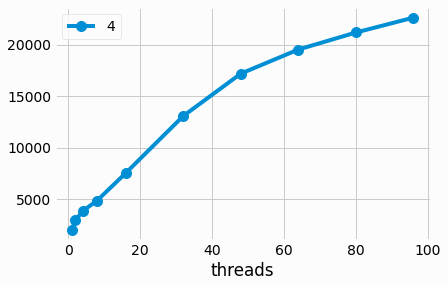

In [96]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for partitions, x in results.groupby('partitions'):
    x.sort_values('threads').plot('threads', 'rate', style='o-', label=str(partitions), ax=ax, ms=10)
#plt.xscale('log')
#plt.xticks(x['threads'], x['threads'])

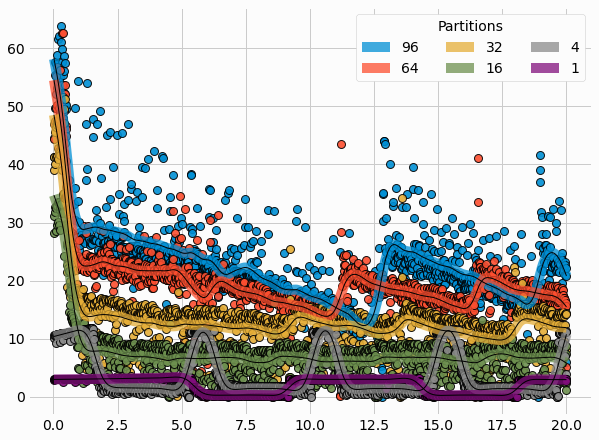

In [97]:
plt.figure(figsize=(9,7))
for color,(_, row) in zip(colors,
            results[results['threads'].isin([1, 4, 16, 32, 64, 96])]
                          .sort_values('threads', ascending=False).iterrows()):
    x = row['results']
    t = x['time']
    t = np.array(t.iloc[1::] - t.iloc[0]) / 60e9
    u = np.array(x['updates']) / 1000
    u = u[1::] - u[:-1:]
    plt.plot(t, u, 'o', color=color, alpha=0.9, ms=8, zorder=1, mec='k')
    
    us = csaps.csaps(t, u, t, smooth=0.9)
    plt.plot(t, us, '-', color=color, lw=10, alpha=0.75, zorder=2, label=row['threads'])
    plt.plot(t, us, '-', color='k', lw=1, alpha=1, zorder=3)


plt.legend(loc='upper right', ncol=3, title='Partitions', framealpha=1)

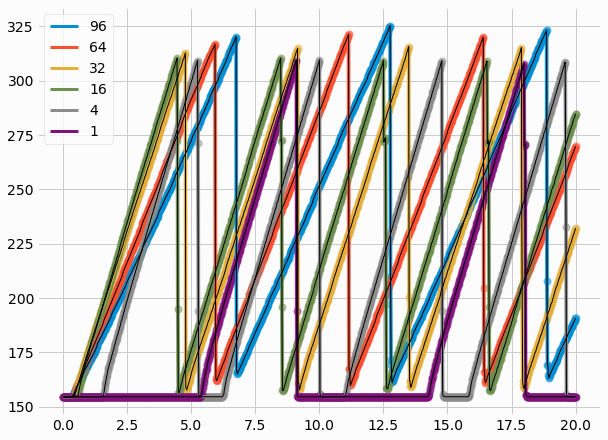

In [98]:
plt.figure(figsize=(9,7))
for color,(_, row) in zip(colors,
            results[results['threads'].isin([1, 4, 16, 32, 64, 96])]
                          .sort_values('threads', ascending=False).iterrows()):
    x = row['results']
    t = x['time']
    t = np.array(t - t.iloc[0]) / 60e9
    s = np.array(x['size']) / 1e9
    plt.plot(t, s, 'o-', color=color, ms=7, alpha=0.5, zorder=1)
    plt.plot(t, s, '-', label=row['threads'], color=color, lw=3, zorder=2)
    plt.plot(t, s, '-', color='k', lw=1, zorder=3)

    
    #ss = csaps.csaps(t, s, t, smooth=0.85)
    #plt.plot(t, ss, '-', color=color)
    
plt.legend(loc='upper left', ncol=1)